In [1]:
import os
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

from torch.utils.data import DataLoader
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import json
import time

In [2]:
ROOT_DIR = './dataset/'
data_path = 'AAPL_reduced_no_date.csv'
target_column = 'close'

# Note to check
#freq

In [10]:
# p = pd.read_csv("./dataset/AAPL_reduced.csv")
# p = p.drop(columns=["date"])
# p.to_csv("./dataset/AAPL_reduced_no_date.csv", index=False)
p = pd.read_csv("./dataset/AAPL_reduced_no_date.csv")
p

open   high    low  close   volume
0     0.796  0.798  0.795  0.797  3662400
1     0.797  0.801  0.795  0.796  1456000
2     0.796  0.800  0.795  0.798  4020800
3     0.797  0.800  0.793  0.797  4065600
4     0.797  0.799  0.792  0.793  8870400
...     ...    ...    ...    ...      ...
9995  0.846  0.851  0.845  0.847   694400
9996  0.847  0.849  0.844  0.847   683200
9997  0.846  0.848  0.844  0.846   851200
9998  0.844  0.847  0.843  0.845   985600
9999  0.845  0.847  0.843  0.845  2721600

[10000 rows x 5 columns]

In [14]:
p['time_id'] = range(0, p.shape[0])
p

open   high    low  close   volume  time_id
0     0.796  0.798  0.795  0.797  3662400        0
1     0.797  0.801  0.795  0.796  1456000        1
2     0.796  0.800  0.795  0.798  4020800        2
3     0.797  0.800  0.793  0.797  4065600        3
4     0.797  0.799  0.792  0.793  8870400        4
...     ...    ...    ...    ...      ...      ...
9995  0.846  0.851  0.845  0.847   694400     9995
9996  0.847  0.849  0.844  0.847   683200     9996
9997  0.846  0.848  0.844  0.846   851200     9997
9998  0.844  0.847  0.843  0.845   985600     9998
9999  0.845  0.847  0.843  0.845  2721600     9999

[10000 rows x 6 columns]

In [15]:
p.to_csv("./dataset/AAPL_reduced_time_id.csv", index=False)

In [4]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'custom' # data
args.root_path =  ROOT_DIR#'/content/' # root path of data file
args.data_path = data_path#'output.csv' # data file
args.features = 'MS' # forecasting task, options:[M, S, MS];
                    #M:multivariate predict multivariate, S:univariate predict univariate,
                    #MS:multivariate predict univariate
args.target = target_column # target feature in S or MS task
args.freq = '1m' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 84 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 8 # encoder input size
args.dec_in = 8 # decoder input size
args.c_out = 8 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 2
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'

In [5]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [6]:
args.data

'custom'

In [7]:
# Set augments by using data name
data_parser = {
    'custom':{'data':data_path,'T':target_column,'M':[6,6,6],'S':[1,1,1],'MS':[5,5,1]}, #Change the array here based on the number of features
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

args.detail_freq = args.freq
args.freq = args.freq[-1:]

Exp = Exp_Informer
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'custom', 'root_path': './dataset/', 'data_path': 'AAPL_reduced_no_date.csv', 'features': 'MS', 'target': 'close', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 84, 'enc_in': 5, 'dec_in': 5, 'c_out': 1, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 2, 'patience': 3, 'des': 'exp', 'use_gpu': False, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [8]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

using mps device
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>


KeyError: "['date'] not in index"

In [ ]:
# set saved model path
setting = 'informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')


# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`

exp = Exp(args)

exp.predict(setting, True)

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

len(data_set), len(data_loader)

using mps device
pred 1


(1, 1)

In [ ]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((1888, 84, 1), (1888, 84, 1))

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(trues, preds, start_index, step, num_plots):
    num_rows = num_plots // 3
    num_cols = 3

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 3 * num_rows), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < num_plots:
            index = start_index + i * step

            ax.plot(trues[index, :, -1], label='GroundTruth')
            ax.plot(preds[index, :, -1], label='Prediction')

            ax.set_title(f'Index {index}')
            ax.legend()
            ax.set_xlabel('time (h)')
            ax.set_ylabel('Close Price')
            ax.tick_params(axis='both', which='both', labelsize=8, direction='in')

        else:
            ax.axis('off')


    plt.tight_layout()
    plt.show()

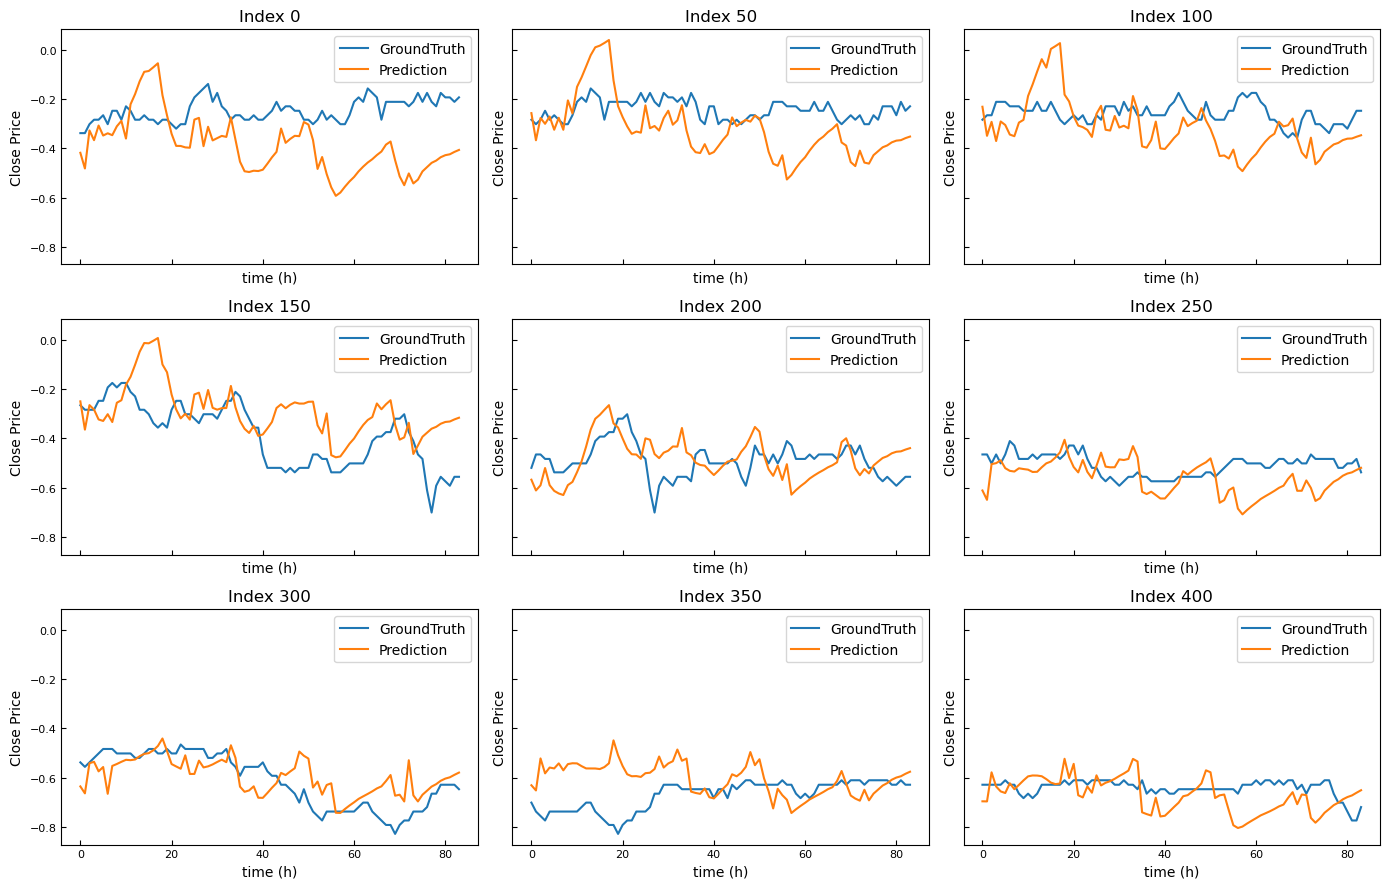

In [ ]:
plot_predictions(trues, preds, start_index=0, step=50, num_plots=9)

In [14]:
import glob
import os
import operator

search_dir = "./informer_checkpoints/"
dirs = os.listdir(search_dir)
dir_list = []
for d in dirs:
    date_change = os.path.getmtime(search_dir + d)
    dir_list.append({'directory_name': d, 'changed_date': date_change})

sorted(dir_list, key=lambda x: x['changed_date'], reverse=True)[0]['directory_name']


'informer_custom_ftMS_sl96_ll48_pl84_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebfixed_dtTrue_mxTrue_exp_0'

In [19]:
import numpy as np
p = np.arange(12)
q = p.reshape(2,2,3)
print('p', p)
print('q ', q)
print(q.shape)

p [ 0  1  2  3  4  5  6  7  8  9 10 11]
q  [[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]]
(2, 2, 3)


In [23]:
import csv
import numpy as np
fil_name = 'file'
example = np.zeros((2,3,4))
print('example shape ', example.shape)
example = example.tolist()
with open(fil_name+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(example)

#to read file you saved
with open(fil_name+'.csv', 'r') as f:
  reader = csv.reader(f)
  examples = list(reader)

print(examples)
nwexamples = []
for row in examples:
    nwrow = []
    for r in row:
        nwrow.append(eval(r))
    nwexamples.append(nwrow)
print(nwexamples)
nwa = np.array(nwexamples)
print('newexamples shape ', nwa.shape)

example shape  (2, 3, 4)
[['[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]'], ['[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]', '[0.0, 0.0, 0.0, 0.0]']]
[[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]]
newexamples shape  (2, 3, 4)


In [157]:
# import pandas as pd
# data = []
# def get_new_data(time_id,id, x1, x2, x3, y):
#     return {'time_id':time_id,'stock_id':id,'x1':x1,'x2':x2,'x3':x3, 'y': y}

# data.append(get_new_data(1,'a', 'a1x1', 'a1x2', 'a1x3', 'a1y1'))
# data.append(get_new_data(1,'b', 'b1x1', 'b1x2', 'b1x3', 'b1y1'))
# # data.append(get_new_data(1,'c', 'c1x1', 'c1x2', 'c1x3', 'c1y1'))
# data.append(get_new_data(2,'a', 'a2x1', 'a2x2', 'a2x3', 'a2y2'))
# data.append(get_new_data(2,'b', 'b2x1', 'b2x2', 'b2x3', 'b2y2'))
# # data.append(get_new_data(2,'c', 'c2x1', 'c2x2', 'c2x3', 'c2y1'))
# data.append(get_new_data(3,'a', 'a3x1', 'a3x2', 'a3x3', 'a3y3'))
# data.append(get_new_data(3,'b', 'b3x1', 'b3x2', 'b3x3', 'b3y3'))
# # data.append(get_new_data(3,'c', 'c3x1', 'c3x2', 'c3x3', 'c3y1'))


# # data.append(get_new_data(1,'a', 1, 1, 1, 2))
# # data.append(get_new_data(1,'b', 3, 3, 3, 4))
# # data.append(get_new_data(2,'a', 5, 5, 5, 6))
# # data.append(get_new_data(2,'b', 7, 7, 7, 8))
# # data.append(get_new_data(3,'a', 9, 9, 9, 10))
# # data.append(get_new_data(3,'b', 11, 11, 11, 12))

# data_df = pd.DataFrame(data)
# data_df


time_id stock_id  x1  x2  x3   y
0        1        a   1   1   1   2
1        1        b   3   3   3   4
2        2        a   5   5   5   6
3        2        b   7   7   7   8
4        3        a   9   9   9  10
5        3        b  11  11  11  12

In [34]:
import pandas as pd

def get_new_data(time_id,id, x1, x2, x3, y):
    return {'time_id':time_id,'stock_id':id,'x1':x1,'x2':x2,'x3':x3, 'y': y}

def generate_data(num_time_ids, num_features, num_of_stocks):
    data = []
    for t in range(1,num_time_ids + 1):
        for s in range(1,num_of_stocks + 1):
            time_id = 't' + str(t)
            stock_id = 's' + str(s)
            row_data = {'time_id': time_id, 'stock_id': stock_id, 'y': 'y' + time_id + stock_id}
            for f in range(1,num_features + 1):
                f_key = 'x'+ str(f)
                row_data[f_key] = time_id + stock_id + f_key

            data.append(row_data)

    return data

data_df = pd.DataFrame(generate_data(10, 3, 4))
data_df
             


time_id stock_id       y       x1       x2       x3
0       t1       s1   yt1s1   t1s1x1   t1s1x2   t1s1x3
1       t1       s2   yt1s2   t1s2x1   t1s2x2   t1s2x3
2       t1       s3   yt1s3   t1s3x1   t1s3x2   t1s3x3
3       t1       s4   yt1s4   t1s4x1   t1s4x2   t1s4x3
4       t2       s1   yt2s1   t2s1x1   t2s1x2   t2s1x3
5       t2       s2   yt2s2   t2s2x1   t2s2x2   t2s2x3
6       t2       s3   yt2s3   t2s3x1   t2s3x2   t2s3x3
7       t2       s4   yt2s4   t2s4x1   t2s4x2   t2s4x3
8       t3       s1   yt3s1   t3s1x1   t3s1x2   t3s1x3
9       t3       s2   yt3s2   t3s2x1   t3s2x2   t3s2x3
10      t3       s3   yt3s3   t3s3x1   t3s3x2   t3s3x3
11      t3       s4   yt3s4   t3s4x1   t3s4x2   t3s4x3
12      t4       s1   yt4s1   t4s1x1   t4s1x2   t4s1x3
13      t4       s2   yt4s2   t4s2x1   t4s2x2   t4s2x3
14      t4       s3   yt4s3   t4s3x1   t4s3x2   t4s3x3
15      t4       s4   yt4s4   t4s4x1   t4s4x2   t4s4x3
16      t5       s1   yt5s1   t5s1x1   t5s1x2   t5s1x3
17      t5       s2   yt5s2   t5s2x1   t5s2x2   t5s2x3
18      t5       s3   yt5s3   t5s3x1   t5s3x2   t5s3x3
19      t5       s4   yt5s4   t5s4x1   t5s4x2   t5s4x3
20      t6       s1   yt6s1   t6s1x1   t6s1x2   t6s1x3
21      t6       s2   yt6s2   t6s2x1   t6s2x2   t6s2x3
22      t6       s3   yt6s3   t6s3x1   t6s3x2   t6s3x3
23      t6       s4   yt6s4   t6s4x1   t6s4x2   t6s4x3
24      t7       s1   yt7s1   t7s1x1   t7s1x2   t7s1x3
25      t7       s2   yt7s2   t7s2x1   t7s2x2   t7s2x3
26      t7       s3   yt7s3   t7s3x1   t7s3x2   t7s3x3
27      t7       s4   yt7s4   t7s4x1   t7s4x2   t7s4x3
28      t8       s1   yt8s1   t8s1x1   t8s1x2   t8s1x3
29      t8       s2   yt8s2   t8s2x1   t8s2x2   t8s2x3
30      t8       s3   yt8s3   t8s3x1   t8s3x2   t8s3x3
31      t8       s4   yt8s4   t8s4x1   t8s4x2   t8s4x3
32      t9       s1   yt9s1   t9s1x1   t9s1x2   t9s1x3
33      t9       s2   yt9s2   t9s2x1   t9s2x2   t9s2x3
34      t9       s3   yt9s3   t9s3x1   t9s3x2   t9s3x3
35      t9       s4   yt9s4   t9s4x1   t9s4x2   t9s4x3
36     t10       s1  yt10s1  t10s1x1  t10s1x2  t10s1x3
37     t10       s2  yt10s2  t10s2x1  t10s2x2  t10s2x3
38     t10       s3  yt10s3  t10s3x1  t10s3x2  t10s3x3
39     t10       s4  yt10s4  t10s4x1  t10s4x2  t10s4x3

In [35]:
import numpy as np
def create_stock_data(data_df, window_len):
    time_ids = list(data_df['time_id'].unique())
    print('time_ids ', time_ids)
    stock_ids = list(data_df['stock_id'].unique())
    print('stock_ids ', stock_ids)
    features = data_df.columns
    # features = [x for x in data_df.columns if x not in ['time_id', 'stock_id']]
    print('features ', features)
    all_data = []
    time_id_counter = 0
    time_id_batch = []
    for time_id in time_ids:
        time_id_counter += 1
        stock_level_data = []
        for stock_id in stock_ids:            
            row_data = data_df[(data_df['time_id'] == time_id) & (data_df['stock_id'] == stock_id)]
            features_data = row_data[features]
            stock_level_data.append(list(features_data.values[0]))

        time_id_batch.append(stock_level_data)

        if time_id_counter == window_len:
            all_data.append(time_id_batch)
            time_id_batch = []
            time_id_counter = 0
            
    all_data_np = np.array(all_data)
    # print('all_data shape ', all_data_np.shape)
    return all_data_np

# num_records (time_ids), window_length (batch), stocks, features
stock_data_np = create_stock_data(data_df, 2)
print('stock_data_np shape ', stock_data_np.shape)
print(stock_data_np[0])

time_ids  ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10']
stock_ids  ['s1', 's2', 's3', 's4']
features  Index(['time_id', 'stock_id', 'y', 'x1', 'x2', 'x3'], dtype='object')
stock_data_np shape  (5, 2, 4, 6)
[[['t1' 's1' 'yt1s1' 't1s1x1' 't1s1x2' 't1s1x3']
  ['t1' 's2' 'yt1s2' 't1s2x1' 't1s2x2' 't1s2x3']
  ['t1' 's3' 'yt1s3' 't1s3x1' 't1s3x2' 't1s3x3']
  ['t1' 's4' 'yt1s4' 't1s4x1' 't1s4x2' 't1s4x3']]

 [['t2' 's1' 'yt2s1' 't2s1x1' 't2s1x2' 't2s1x3']
  ['t2' 's2' 'yt2s2' 't2s2x1' 't2s2x2' 't2s2x3']
  ['t2' 's3' 'yt2s3' 't2s3x1' 't2s3x2' 't2s3x3']
  ['t2' 's4' 'yt2s4' 't2s4x1' 't2s4x2' 't2s4x3']]]


In [29]:
stock_data_np[0]

array([], dtype=float64)

In [ ]:


# data.append(get_new_data(1,'a', 'a1x1', 'a1x2', 'a1x3', 'a1y1'))
# data.append(get_new_data(1,'b', 'b1x1', 'b1x2', 'b1x3', 'b1y1'))
# data.append(get_new_data(2,'a', 'a2x1', 'a2x2', 'a2x3', 'a2y2'))
# data.append(get_new_data(2,'b', 'b2x1', 'b2x2', 'b2x3', 'b2y2'))
# data.append(get_new_data(3,'a', 'a3x1', 'a3x2', 'a3x3', 'a3y3'))
# data.append(get_new_data(3,'b', 'b3x1', 'b3x2', 'b3x3', 'b3y3'))

# data_df = pd.DataFrame(data)
# display(data_df)

# sample_3d = create_3d_stock_data(data_df)
# print('sample_3d shape ', sample_3d.shape)

# # single record contains record for one time id
# # first_record = sample_3d[0]
# # print('first_record ', first_record)

# # first_stock_record = first_record[0]
# # print('first_stock_record ', first_stock_record)

# # target_data = first_stock_record[-1]
# # print('target_data ', target_data)

# print('Batch record')
# # batch record, suppose 2 time id
# batch_record = sample_3d[0:2]
# print('batch_record ', batch_record)

# features = batch_record[:,:,0:-1]
# print('\nfeatures ', features)
# targets = batch_record[:,:,-1]
# print('\ntargets ', targets)

# stock(num_stock), time_id(window_len), features (num_features)
# inputs: [batch - splits the time_id, num_stock, window_len, num_features]

In [ ]:
# all_all_data = []
# batch_size = 2
# row_start = 0
# num_of_iterations = len(sample_3d) / batch_size
# for i in range(num_of_iterations)
# batch_record = sample_3d[0:2]

In [188]:
batch_record.shape

(2, 2, 4)

In [195]:
import pandas as pd
data = []
def get_new_data(time_id,id, x1, x2, x3, y):
    return {'time_id':time_id,'stock_id':id,'x1':x1,'x2':x2,'x3':x3, 'y': y}

data.append(get_new_data(1,'a', 1, 1, 1, 2))
data.append(get_new_data(1,'b', 3, 3, 3, 4))
data.append(get_new_data(2,'a', 5, 5, 5, 6))
data.append(get_new_data(2,'b', 7, 7, 7, 8))
data.append(get_new_data(3,'a', 9, 9, 9, 10))
data.append(get_new_data(3,'b', 11, 11, 11, 12))

data_df = pd.DataFrame(data)
display(data_df)

sample_3d = create_3d_stock_data(data_df)
print('sample_3d shape ', sample_3d.shape)

# # single record contains record for one time id
# first_record = sample_3d[0]
# print('first_record ', first_record)

# first_stock_record = first_record[0]
# print('first_stock_record ', first_stock_record)

# target_data = first_stock_record[-1]
# print('target_data ', target_data)

print('Batch record')
# batch record, suppose 2 time id
batch_record = sample_3d[0:2]
print('batch_record ', batch_record)

features = batch_record[:,:,0:-1]
print('features ', features)
targets = batch_record[:,:,-1]
print('targets ', targets)


# eg. time_id of 3000, each piece with 30 (window len), then total of 100 (number of rows)
# stock, time_id, features

time_id stock_id  x1  x2  x3   y
0        1        a   1   1   1   2
1        1        b   3   3   3   4
2        2        a   5   5   5   6
3        2        b   7   7   7   8
4        3        a   9   9   9  10
5        3        b  11  11  11  12

time_ids  [1, 2, 3]
stock_ids  ['a', 'b']
features  ['x1', 'x2', 'x3', 'y']
sample_3d shape  (2, 3, 4)
Batch record
batch_record  [[[ 1  1  1  2]
  [ 5  5  5  6]
  [ 9  9  9 10]]

 [[ 3  3  3  4]
  [ 7  7  7  8]
  [11 11 11 12]]]
features  [[[ 1  1  1]
  [ 5  5  5]
  [ 9  9  9]]

 [[ 3  3  3]
  [ 7  7  7]
  [11 11 11]]]
targets  [[ 2  6 10]
 [ 4  8 12]]


In [199]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class CustomStockDataset(Dataset):
    def __init__(self, stocks_data):
        self.stocks_data = stocks_data

    def __len__(self):
        return len(self.stocks_data)

    def __getitem__(self, idx):
        print('stocks data shape ', self.stocks_data.shape)
        row_data = self.stocks_data[idx]
        print('row_data shape ', row_data.shape)
        print('row_data', row_data)
        features = row_data[:,0:-1]
        print('features ', features)
        targets = row_data[:,-1]
        print('targets ', targets)
        return features, targets

from torch.utils.data import DataLoader
stock_dataset = CustomStockDataset(sample_3d)
stock_dataloader = DataLoader(stock_dataset, batch_size=2, shuffle=False)

d4 = []
for dl in stock_dataloader:
    # print(dl[0].shape)
    d4.append(dl)

# train_features, train_labels = next(iter(stock_dataloader))
# print('train_features ', train_features)
# print('train_labels ', train_labels)

stocks data shape  (2, 3, 4)
row_data shape  (3, 4)
row_data [[ 1  1  1  2]
 [ 5  5  5  6]
 [ 9  9  9 10]]
features  [[1 1 1]
 [5 5 5]
 [9 9 9]]
targets  [ 2  6 10]
stocks data shape  (2, 3, 4)
row_data shape  (3, 4)
row_data [[ 3  3  3  4]
 [ 7  7  7  8]
 [11 11 11 12]]
features  [[ 3  3  3]
 [ 7  7  7]
 [11 11 11]]
targets  [ 4  8 12]
torch.Size([2, 3, 3])


NameError: name 'fdsa' is not defined

In [165]:
import pandas as pd
import os
def read_stock_data(stock_id):
    data_dir = '/Users/pujanmaharjan/uni adelaide/uofa_research_project/datasets/optiver-realized-volatility-prediction/book_train.parquet/stock_id='+stock_id
    filename = os.listdir(data_dir)[0]
    df = pd.read_parquet(data_dir + "/" + filename)
    df_agg = df.groupby(by='time_id').sum()
    df_agg['time_id'] = df_agg.index
    df_agg['stock_id'] = stock_id
    df_agg = df_agg.drop(columns=["seconds_in_bucket"])
    df_agg.index = range(len(df_agg))
    return df_agg

stock_ids = ['0', '1']
all_stock_df = pd.DataFrame()
for stock_id in stock_ids:
    stock_df = read_stock_data(stock_id)
    all_stock_df = pd.concat([all_stock_df, stock_df], ignore_index=True)
    print('all_stock_df ', all_stock_df.shape)

all_stock_df



all_stock_df  (3830, 10)
all_stock_df  (7660, 10)


bid_price1  ask_price1  bid_price2  ask_price2  bid_size1  ask_size1  \
0     303.000854  303.259064  302.947845  303.304626      23636      22523   
1     200.002258  200.081116  199.973907  200.108109      29993      14229   
2     187.850311  187.986603  187.813354  188.023834      18073      24635   
3     119.813408  119.916534  119.790642  119.929535      13735      14496   
4     175.895645  175.965515  175.862076  175.984711      21089      15572   
...          ...         ...         ...         ...        ...        ...   
7655  306.944916  307.128357  306.896698  307.164642      23250      18401   
7656  497.494507  497.954102  497.415863  498.016022      63667      91691   
7657  313.132782  313.335693  313.088776  313.376862      38901      22370   
7658  435.233521  435.416931  435.151245  435.517181      55774      65126   
7659  304.979797  305.065521  304.942902  305.102417      54172      59414   

      bid_size2  ask_size2  time_id stock_id  
0         24426      27111        5        0  
1         19089      18979       11        0  
2         21531      14035       16        0  
3          8254      15747       31        0  
4         15460       8286       62        0  
...         ...        ...      ...      ...  
7655      20104      29174    32751        1  
7656      42370      82785    32753        1  
7657      44453      27803    32758        1  
7658      50106      57416    32763        1  
7659      47330      56713    32767        1  

[7660 rows x 10 columns]

In [166]:
# train csv
train_path = '/Users/pujanmaharjan/uni adelaide/uofa_research_project/datasets/optiver-realized-volatility-prediction/train.csv'
train_data = pd.read_csv(train_path)
train_data



stock_id  time_id    target
0              0        5  0.004136
1              0       11  0.001445
2              0       16  0.002168
3              0       31  0.002195
4              0       62  0.001747
...          ...      ...       ...
428927       126    32751  0.003461
428928       126    32753  0.003113
428929       126    32758  0.004070
428930       126    32763  0.003357
428931       126    32767  0.002090

[428932 rows x 3 columns]

In [167]:
train_data[(train_data['stock_id'] == 0) & (train_data['time_id'] == 5)]['target'].values

array([0.00413577])

In [168]:
targets = []
for index, row in all_stock_df.iterrows():
    stock_id = int(row['stock_id'])
    time_id = int(row['time_id'])
    target = train_data[(train_data['stock_id'] == stock_id) & (train_data['time_id'] == time_id)]['target'].values[0]
    targets.append(target)

In [169]:
all_stock_df['target'] = targets

In [170]:
all_stock_df

bid_price1  ask_price1  bid_price2  ask_price2  bid_size1  ask_size1  \
0     303.000854  303.259064  302.947845  303.304626      23636      22523   
1     200.002258  200.081116  199.973907  200.108109      29993      14229   
2     187.850311  187.986603  187.813354  188.023834      18073      24635   
3     119.813408  119.916534  119.790642  119.929535      13735      14496   
4     175.895645  175.965515  175.862076  175.984711      21089      15572   
...          ...         ...         ...         ...        ...        ...   
7655  306.944916  307.128357  306.896698  307.164642      23250      18401   
7656  497.494507  497.954102  497.415863  498.016022      63667      91691   
7657  313.132782  313.335693  313.088776  313.376862      38901      22370   
7658  435.233521  435.416931  435.151245  435.517181      55774      65126   
7659  304.979797  305.065521  304.942902  305.102417      54172      59414   

      bid_size2  ask_size2  time_id stock_id    target  
0         24426      27111        5        0  0.004136  
1         19089      18979       11        0  0.001445  
2         21531      14035       16        0  0.002168  
3          8254      15747       31        0  0.002195  
4         15460       8286       62        0  0.001747  
...         ...        ...      ...      ...       ...  
7655      20104      29174    32751        1  0.003741  
7656      42370      82785    32753        1  0.012414  
7657      44453      27803    32758        1  0.002868  
7658      50106      57416    32763        1  0.004902  
7659      47330      56713    32767        1  0.002204  

[7660 rows x 11 columns]

In [171]:
stock_3d = create_data(all_stock_df)
print('stock_3d shape ', stock_3d.shape)

time_ids  [5, 11, 16, 31, 62, 72, 97, 103, 109, 123, 128, 146, 147, 152, 157, 159, 169, 207, 211, 213, 218, 227, 229, 232, 250, 254, 256, 266, 273, 289, 297, 303, 309, 310, 317, 319, 325, 326, 335, 337, 358, 371, 373, 380, 381, 411, 420, 424, 427, 436, 438, 454, 465, 468, 487, 493, 506, 535, 536, 539, 545, 554, 568, 579, 589, 591, 595, 611, 618, 627, 633, 640, 646, 650, 652, 659, 675, 697, 709, 725, 728, 735, 745, 746, 748, 753, 785, 817, 840, 841, 852, 854, 868, 886, 895, 904, 908, 947, 951, 957, 969, 985, 991, 1000, 1011, 1016, 1020, 1022, 1028, 1037, 1040, 1057, 1063, 1070, 1075, 1100, 1107, 1119, 1125, 1128, 1135, 1142, 1149, 1158, 1161, 1173, 1176, 1178, 1191, 1198, 1205, 1209, 1213, 1215, 1219, 1227, 1235, 1239, 1242, 1247, 1249, 1255, 1264, 1269, 1273, 1274, 1280, 1289, 1291, 1292, 1302, 1310, 1321, 1322, 1326, 1348, 1350, 1359, 1363, 1365, 1377, 1380, 1392, 1404, 1408, 1416, 1417, 1427, 1430, 1433, 1459, 1462, 1463, 1464, 1468, 1471, 1477, 1481, 1501, 1513, 1521, 1524, 1529, 15

In [172]:
type(stock_3d)

numpy.ndarray

In [173]:
with open('stocks_data.npy', 'wb') as f:
    np.save(f, stock_3d)

In [174]:
with open('stocks_data.npy', 'rb') as f:
    p = np.load(f)
    print('p ', p.shape)

p  (3830, 2, 9)


In [122]:
stock_3d[0]

array([[3.03000854e+02, 3.03259064e+02, 3.02947845e+02, 3.03304626e+02,
        2.36360000e+04, 2.25230000e+04, 2.44260000e+04, 2.71110000e+04,
        4.13576700e-03],
       [5.76905212e+02, 5.77288269e+02, 5.76840393e+02, 5.77351440e+02,
        3.57500000e+04, 6.37770000e+04, 3.11720000e+04, 3.47220000e+04,
        6.34014400e-03]])